# CoinGame solver using individual actor-critic (IAC) agents

In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import warnings
# warnings.filterwarnings('error', message=r".*complex128.*")
# warnings.simplefilter('module')

# from silence_tensorflow import silence_tensorflow
# silence_tensorflow()

import eqmarl
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf

In [37]:
# # Disable GPUs.
# tf.config.set_visible_devices([], 'GPU')

# List any available GPUs.
tf.config.list_physical_devices('GPU')

[]

In [38]:
n_agents = 2
n_layers = 5
n_actions = 4 # CoinGame2 has 4 actions (north/south/east/west)
joint_action_map = eqmarl.generate_discrete_joint_action_map(n_agents=n_agents, n_actions=n_actions) # Maps joint action --> per-agent action

In [39]:
# Individual quantum actors.
model_actors = [
    eqmarl.generate_model_CoinGame2_actor_quantum(
        n_layers=n_layers,
        name=f"actor-quantum-{i}",
        )
    for i in range(n_agents)
]

optimizer_actor = keras.optimizers.Adam(learning_rate=0.1)

# # Individual classical actors.
# model_actors = [
#     eqmarl.generate_model_CoinGame2_actor_classical(
#         n_actions=n_actions,
#         units=[128, 64, 32],
#         name=f"actor-classical-{i}"
#         )
#     for i in range(n_agents)
# ]

for m in model_actors:
    m.build((None, 36))
    m.summary()

Model: "actor-quantum-0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input-preprocess (Sequentia  (None, 4, 3)             0         
 l)                                                              
                                                                 
 HybridVariationalEncodingPQ  (None, 4)                132       
 C (HybridVariationalEncodin                                     
 gPQC)                                                           
                                                                 
 observables-policy (Sequent  (None, 4)                4         
 ial)                                                            
                                                                 
Total params: 136
Trainable params: 136
Non-trainable params: 0
_________________________________________________________________
Model: "actor-quantum-1"
____________________________

In [40]:
# Individual quantum critics.
model_critics = [
    eqmarl.generate_model_CoinGame2_critic_classical(
        units=[128, 64, 32],
        name=f"critic-classical-{i}",
        )
    for i in range(n_agents)
]

optimizer_critic = keras.optimizers.Adam(learning_rate=0.001)

for m in model_critics:
    m.build((None, 36))
    m.summary()



# model_critic = generate_model_CoinGame2_critic([128, 64, 32], name='critic-classical')
# model_critic.build((None, n_agents, 36))
# model_critic.summary()

Model: "critic-classical-0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 36)                0         
                                                                 
 dense_24 (Dense)            (None, 128)               4736      
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dense_26 (Dense)            (None, 32)                2080      
                                                                 
 v (Dense)                   (None, 1)                 33        
                                                                 
Total params: 15,105
Trainable params: 15,105
Non-trainable params: 0
_________________________________________________________________
Model: "critic-classical-1"
________________

## Training

In [41]:
gamma = 0.95
env_params = {
    "domain_name": "CoinGame-2",
    "R_max": 2,
    "time_limit": 50,
    "gamma": gamma,
}
trainer = eqmarl.trainers.CoinGame2Trainer(env_params=env_params)

In [42]:
multiagent = eqmarl.agents.IAC(
    model_actors=model_actors,
    model_critics=model_critics,
    gamma=gamma,
    optimizer_actor=optimizer_actor,
    optimizer_critic=optimizer_critic,
    n_actions=n_actions,
    )

n_episodes = 100

metrics_history = trainer.train(
    n_episodes=n_episodes,
    multiagent=multiagent,
    reward_termination_threshold=10, # Stop after reward 
    report_interval=10,
    )

Episode 0:   0%|          | 0/100 [00:00<?, ?episode/s]

Episode 10:   9%|▉         | 9/100 [00:12<01:52,  1.24s/episode, episode_coins_collected=12, episode_discounted_reward=0.519, episode_own_coin_rate=0.667, episode_own_coins_collected=8, episode_reward=4, episode_undiscounted_reward=4] 

Episode 10/100, average last 10 rewards 0.10000000149011612: avg_undiscounted_rewards=0.1, avg_discounted_rewards=0.32949569172281706, avg_coins_collected=8.3, avg_own_coins_collected=4.2, avg_own_coin_rate=0.5121578421578422


Episode 20:  19%|█▉        | 19/100 [00:25<01:40,  1.24s/episode, episode_coins_collected=3, episode_discounted_reward=0.985, episode_own_coin_rate=0.667, episode_own_coins_collected=2, episode_reward=1, episode_undiscounted_reward=1]   

Episode 20/100, average last 10 rewards 0.20000000298023224: avg_undiscounted_rewards=0.2, avg_discounted_rewards=0.2625583993037264, avg_coins_collected=5.6, avg_own_coins_collected=2.9, avg_own_coin_rate=0.5652380952380953


Episode 30:  29%|██▉       | 29/100 [00:37<01:28,  1.25s/episode, episode_coins_collected=12, episode_discounted_reward=-.645, episode_own_coin_rate=0.5, episode_own_coins_collected=6, episode_reward=0, episode_undiscounted_reward=0]    

Episode 30/100, average last 10 rewards -0.6000000238418579: avg_undiscounted_rewards=-0.6, avg_discounted_rewards=-0.4284130067817701, avg_coins_collected=5.8, avg_own_coins_collected=2.6, avg_own_coin_rate=0.39516594516594516


Episode 40:  39%|███▉      | 39/100 [00:49<01:15,  1.24s/episode, episode_coins_collected=14, episode_discounted_reward=0.528, episode_own_coin_rate=0.5, episode_own_coins_collected=7, episode_reward=0, episode_undiscounted_reward=0]   

Episode 40/100, average last 10 rewards 0.6000000238418579: avg_undiscounted_rewards=0.6, avg_discounted_rewards=0.10520234778105472, avg_coins_collected=6.2, avg_own_coins_collected=3.4, avg_own_coin_rate=0.5416666666666666


Episode 50:  49%|████▉     | 49/100 [01:03<01:12,  1.43s/episode, episode_coins_collected=5, episode_discounted_reward=0.772, episode_own_coin_rate=0.8, episode_own_coins_collected=4, episode_reward=3, episode_undiscounted_reward=3]    

Episode 50/100, average last 10 rewards -0.20000000298023224: avg_undiscounted_rewards=-0.2, avg_discounted_rewards=-0.2560669266829084, avg_coins_collected=5.0, avg_own_coins_collected=2.4, avg_own_coin_rate=0.4978571428571428


Episode 60:  59%|█████▉    | 59/100 [01:17<00:54,  1.34s/episode, episode_coins_collected=3, episode_discounted_reward=0.0213, episode_own_coin_rate=0.667, episode_own_coins_collected=2, episode_reward=1, episode_undiscounted_reward=1]  

Episode 60/100, average last 10 rewards 0.10000000149011612: avg_undiscounted_rewards=0.1, avg_discounted_rewards=-0.1830918681990754, avg_coins_collected=5.9, avg_own_coins_collected=3.0, avg_own_coin_rate=0.5430555555555556


Episode 70:  69%|██████▉   | 69/100 [01:31<00:45,  1.46s/episode, episode_coins_collected=7, episode_discounted_reward=0.655, episode_own_coin_rate=0.571, episode_own_coins_collected=4, episode_reward=1, episode_undiscounted_reward=1]  

Episode 70/100, average last 10 rewards 0.699999988079071: avg_undiscounted_rewards=0.7, avg_discounted_rewards=0.43550755576770134, avg_coins_collected=5.9, avg_own_coins_collected=3.3, avg_own_coin_rate=0.6201556776556776


Episode 80:  79%|███████▉  | 79/100 [01:45<00:30,  1.47s/episode, episode_coins_collected=0, episode_discounted_reward=0, episode_own_coin_rate=0, episode_own_coins_collected=0, episode_reward=0, episode_undiscounted_reward=0]           

Episode 80/100, average last 10 rewards 0.6000000238418579: avg_undiscounted_rewards=0.6, avg_discounted_rewards=0.08158877287447741, avg_coins_collected=4.6, avg_own_coins_collected=2.6, avg_own_coin_rate=0.5452380952380953


Episode 90:  89%|████████▉ | 89/100 [01:58<00:14,  1.29s/episode, episode_coins_collected=8, episode_discounted_reward=-.941, episode_own_coin_rate=0.375, episode_own_coins_collected=3, episode_reward=-2, episode_undiscounted_reward=-2]

Episode 90/100, average last 10 rewards -1.0: avg_undiscounted_rewards=-1.0, avg_discounted_rewards=-0.9093997583913105, avg_coins_collected=5.8, avg_own_coins_collected=2.4, avg_own_coin_rate=0.3303787878787879


Episode 100:  99%|█████████▉| 99/100 [02:11<00:01,  1.27s/episode, episode_coins_collected=4, episode_discounted_reward=0.55, episode_own_coin_rate=0.5, episode_own_coins_collected=2, episode_reward=0, episode_undiscounted_reward=0]    

Episode 100/100, average last 10 rewards 0.699999988079071: avg_undiscounted_rewards=0.7, avg_discounted_rewards=0.35276053792114176, avg_coins_collected=5.5, avg_own_coins_collected=3.1, avg_own_coin_rate=0.5006471306471306


Episode 100: 100%|██████████| 100/100 [02:11<00:00,  1.31s/episode, episode_coins_collected=4, episode_discounted_reward=0.55, episode_own_coin_rate=0.5, episode_own_coins_collected=2, episode_reward=0, episode_undiscounted_reward=0]


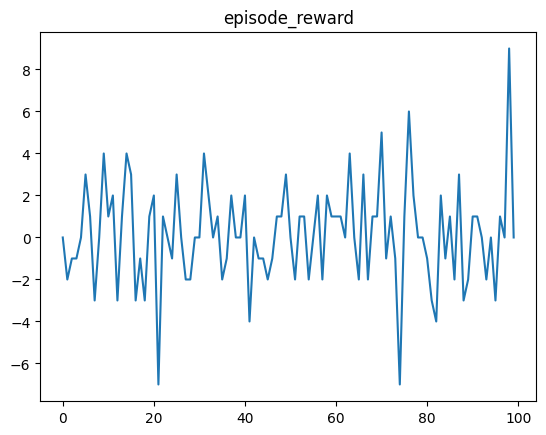

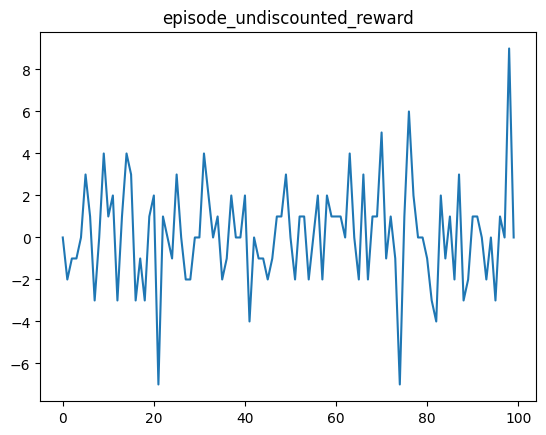

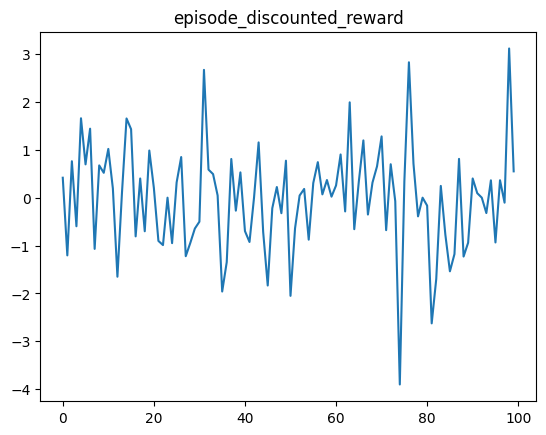

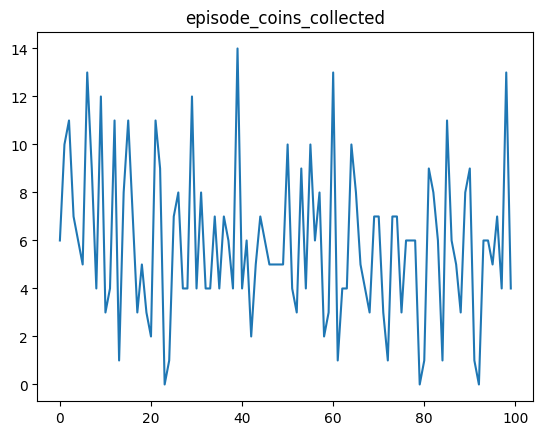

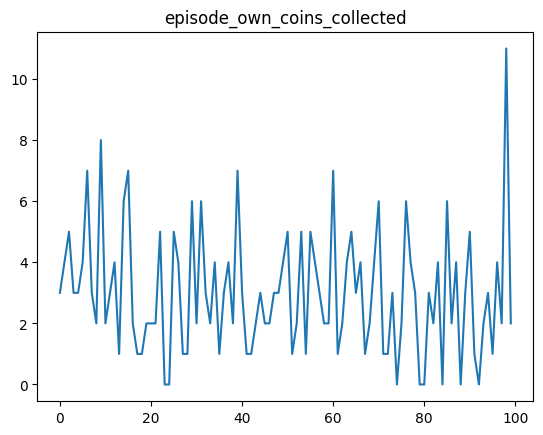

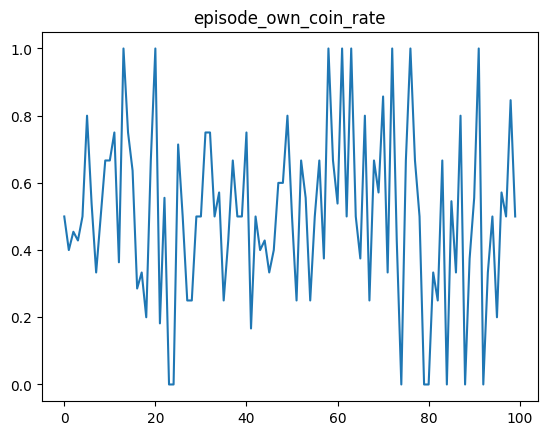

In [43]:
for k, data in metrics_history.items():
    plt.figure()
    plt.plot(data)
    plt.title(k)